In [1]:
import numpy as nu
import matplotlib.pyplot as plt
from galpy.potential import SCFPotential
from IPython.display import display, Math, Latex
%matplotlib inline  

#SCFPotential

## Examples

### Spherical density 

Consider $\rho (r) = \frac{1}{2\pi} \frac{1}{r (1 + r)^3}$

We get $A_{nlm} = \delta_{n0}\delta_{l0}\delta_{m0}$

In [2]:
def rho_Spherical(r):
    return (2*nu.pi)**-1 * (r*(1 + r)**3)**-1

def sphericalA(N,L):
    A = nu.zeros((N,L,L), complex)
    A[0,0,0] = 1.
    return nu.real(A), nu.imag(A)

In [3]:
Areal, Aimag = sphericalA(2,2) 

Creating the SCFPotential object

In [4]:
scf = SCFPotential(1., Areal, Aimag)

In [5]:
R = nu.linspace(0.01, 1., 1000)
density = nu.zeros(1000, float)
densityAnalytic = rho_Spherical(R)
for i in range(len(R)):
    density[i] = scf.dens(R[i], 0)

x = densityAnalytic/density

print "The scale factor between the two densities are, {0} +/- {1}".format(nu.mean(x), nu.std(x))
##Normalizing
density /= nu.max(density)
densityAnalytic /= nu.max(densityAnalytic)

The scale factor between the two densities are, 1.0 +/- 1.81717430244e-16


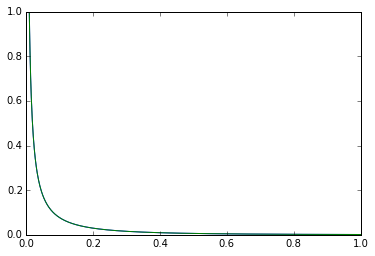

In [6]:
plt.plot(R, density)
plt.plot(R, densityAnalytic)

We confirm that our numerical density matches with our analytic density

### Zeeuw's perfect ellipsoid

Consider $\rho (r) = \frac{3}{4\pi} \frac{1}{(1 + r)^4}$

We get $A_{nlm} = \frac{3}{4}\delta_{n0}\delta_{l0}\delta_{m0} + \frac{1}{12}\delta_{n1}\delta_{l0}\delta_{m0}$

In [7]:
def rho_Zeeuw(r):
    return 3./(4*nu.pi) * (1. + r)**-4.

def ZeeuwA(N,L):
    A = nu.zeros((N,L,L), complex)
    A[0,0,0] = 3./4
    A[1,0,0] = 1./12
    return nu.real(A), nu.imag(A)

In [8]:
Areal, Aimag = ZeeuwA(10,10) 
scf = SCFPotential(1., Areal, Aimag)

In [9]:
R = nu.linspace(0.01, 1., 1000)
density = nu.zeros(1000, float)
densityAnalytic = rho_Zeeuw(R)
for i in range(len(R)):
    density[i] = scf.dens(R[i], 0, 10)

x = densityAnalytic/density
print "The scale factor between the two densities are, {0} +/- {1}".format(nu.mean(x), nu.std(x))

##Normalizing
density /= nu.max(density)
densityAnalytic /= nu.max(densityAnalytic)

The scale factor between the two densities are, 0.505 +/- 0.286074314669


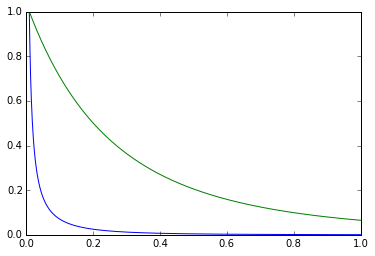

In [10]:
plt.plot(R, density)
plt.plot(R, densityAnalytic)